In [63]:
%matplotlib inline

In [64]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import numpy as np
import os
import matplotlib.pyplot as plt

In [65]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [66]:
# Load the data
train_x = np.load("/home/xk/pht/smallproject/12.24/data/AddNIST/train_x.npy")
train_y = np.load("/home/xk/pht/smallproject/12.24/data/AddNIST/train_y.npy")
test_x = np.load("/home/xk/pht/smallproject/12.24/data/AddNIST/test_x.npy")
test_y = np.load("/home/xk/pht/smallproject/12.24/data/AddNIST/test_y.npy")
valid_x = np.load("/home/xk/pht/smallproject/12.24/data/AddNIST/valid_x.npy")
valid_y = np.load("/home/xk/pht/smallproject/12.24/data/AddNIST/valid_y.npy")
print(f"PyTorch CUDA version: {torch.version.cuda}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Current CUDA device: {torch.cuda.current_device()}")
    print(f"CUDA device name: {torch.cuda.get_device_name()}")

PyTorch CUDA version: 12.1
CUDA available: True
Current CUDA device: 0
CUDA device name: NVIDIA GeForce RTX 3090


In [67]:
print("train_x:",train_x.shape)
print("train_y:",train_y.shape)
print("test_x:",test_x.shape)
print("test_y:",test_y.shape)
print("valid_x:",valid_x.shape)
print("valid_y:",valid_y.shape)

train_x: (45000, 3, 28, 28)
train_y: (45000,)
test_x: (10000, 3, 28, 28)
test_y: (10000,)
valid_x: (15000, 3, 28, 28)
valid_y: (15000,)


In [68]:
class SimpleClassifier(nn.Module):
    def __init__(self):
        super(SimpleClassifier, self).__init__()
        # First convolutional block
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        
        # Second convolutional block
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        
        # Third convolutional block
        self.conv3 = nn.Conv2d(32, 48, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(48)
        
        # Fourth convolutional block
        self.conv4 = nn.Conv2d(48, 62, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(62)
        
        self.conv5 = nn.Conv2d(62, 62, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(62)
        # Fully connected layers
        self.fc1 = nn.Linear(62, 128)
        self.dropout1 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(64, 20)

    def forward(self, x):
        # print(f"Input shape: {x.shape}")
        # First block
        x = self.bn1(self.conv1(x))
        x = F.relu(x)
        # print(f"Before block 1: {x.shape}")
        x = F.max_pool2d(x, 2)
        # print(f"After block 1: {x.shape}")
        
        # Second block
        x = self.bn2(self.conv2(x))
        x = F.relu(x)
        # print(f"Before block 2: {x.shape}")
        x = F.max_pool2d(x, 2)
        # print(f"After block 2: {x.shape}")
        
        # Third block
        x = self.bn3(self.conv3(x))
        x = F.relu(x)
        # print(f"Before block 3: {x.shape}")
        x = F.max_pool2d(x, 2)
        # print(f"After block 3: {x.shape}")
        
        # Fourth block
        x = self.bn4(self.conv4(x))
        x = F.relu(x)
        # print(f"Before block 4: {x.shape}")
        x = F.max_pool2d(x, 2,stride=1)
        # print(f"After block 4: {x.shape}")
        
        # # Fifth block
        x = self.bn5(self.conv5(x))
        x = F.relu(x)
        # print(f"Before block 5: {x.shape}")
        x = F.max_pool2d(x, 2)
        # print(f"After block 5: {x.shape}")
        
        # Flatten and fully connected layers
        x = x.view(x.size(0), -1)    # Flatten to (batch_size, 1152)
        # print(f"After flatten: {x.shape}")
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        # print(f"After fc3: {x.shape}")
        
        return x

class AddnistDataset(Dataset):
    def __init__(self, data, labels, is_training=False):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.is_training = is_training

    def __len__(self):
        return len(self.data)

    def random_shift(self, x, max_shift=2):
        _, h, w = x.shape
        shift_x = np.random.randint(-max_shift, max_shift + 1)
        shift_y = np.random.randint(-max_shift, max_shift + 1)
        x_shifted = torch.roll(x, shifts=(shift_y, shift_x), dims=(1, 2))
        return x_shifted

    def __getitem__(self, idx):
        x = self.data[idx]
        if self.is_training:
            # Add random noise
            if np.random.random() < 0.5:
                noise = torch.randn_like(x) * 0.1
                x = x + noise
                x = torch.clamp(x, 0, 1)
            
            # Random horizontal flip
            if np.random.random() < 0.5:
                x = torch.flip(x, dims=[2])
                
            # Random shift
            if np.random.random() < 0.5:
                x = self.random_shift(x)
                
        return x, self.labels[idx]

In [69]:
def train_model(model, train_loader, valid_loader, epochs=1000, learning_rate=0.001, patience=7):
    model = model.to(device)  # Move model to GPU
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)
    
    # Lists to store metrics for plotting
    train_losses = []
    train_accs = []
    valid_losses = []
    valid_accs = []
    
    best_val_acc = 0
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            # Move data to GPU
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            # print(f"Outputs shape: {outputs.shape}")  # Add this line
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        
        # Store training metrics
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Training - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valid_loader)
        val_accuracy = 100 * val_correct / val_total
        
        # Store validation metrics
        valid_losses.append(val_loss)
        valid_accs.append(val_accuracy)
        
        print(f"Validation - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")
        
        scheduler.step(val_accuracy)
        
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"Early stopping triggered after epoch {epoch+1}")
            model.load_state_dict(best_model_state)
            break
    
    # Plot the metrics
    plt.figure(figsize=(12, 4))
    
    # Plot loss curves
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(valid_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    
    # Save the figure
    plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight')
    
    return model

In [70]:

def save_model(model, save_dir, filename):
    """
    Save the model architecture and weights
    """
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Save the full model architecture and weights
    model_path = os.path.join(save_dir, f"{filename}.pth")
    torch.save({
        'model_state_dict': model.state_dict(),
        'model_architecture': type(model).__name__,
        'model_config': model.__dict__,
    }, model_path)
    print(f"Model saved to {model_path}")

def load_model(model_path):
    """
    Load a saved model
    """
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"No model found at {model_path}")
    
    # Load the saved model data
    checkpoint = torch.load(model_path)
    
    # Create a new instance of the same model architecture
    model = SimpleClassifier()
    
    # Load the saved weights
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Model loaded from {model_path}")
    return model

def test_model(model, test_loader):
    """
    Evaluate the model on the test dataset
    """
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

In [71]:

# Prepare datasets and dataloaders
train_dataset = AddnistDataset(train_x, train_y, is_training=True)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

valid_dataset = AddnistDataset(valid_x, valid_y, is_training=False)
valid_dataloader = DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=2)

test_dataset = AddnistDataset(test_x, test_y, is_training=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)


for batch_x, batch_y in train_dataloader:
    print("Batch x shape:", batch_x.shape)
    print("Batch y shape:", batch_y.shape)
    break


Batch x shape: torch.Size([64, 3, 28, 28])
Batch y shape: torch.Size([64])


Number of parameters: 98524
Epoch 1/200
Training - Loss: 2.5974, Accuracy: 12.55%
Validation - Loss: 2.9736, Accuracy: 11.89%
Epoch 2/200
Training - Loss: 2.3199, Accuracy: 18.40%
Validation - Loss: 2.1562, Accuracy: 23.47%
Epoch 3/200
Training - Loss: 2.2278, Accuracy: 21.65%
Validation - Loss: 2.0917, Accuracy: 25.25%
Epoch 4/200
Training - Loss: 2.1713, Accuracy: 23.13%
Validation - Loss: 2.0631, Accuracy: 27.17%
Epoch 5/200
Training - Loss: 2.1104, Accuracy: 25.16%
Validation - Loss: 2.0793, Accuracy: 27.43%
Epoch 6/200
Training - Loss: 2.0698, Accuracy: 26.58%
Validation - Loss: 2.0975, Accuracy: 27.25%
Epoch 7/200
Training - Loss: 2.0334, Accuracy: 27.85%
Validation - Loss: 1.9466, Accuracy: 29.88%
Epoch 8/200
Training - Loss: 1.9954, Accuracy: 29.47%
Validation - Loss: 1.8845, Accuracy: 32.96%
Epoch 9/200
Training - Loss: 1.9628, Accuracy: 31.24%
Validation - Loss: 1.9589, Accuracy: 32.49%
Epoch 10/200
Training - Loss: 1.9207, Accuracy: 32.34%
Validation - Loss: 1.8223, Accuracy

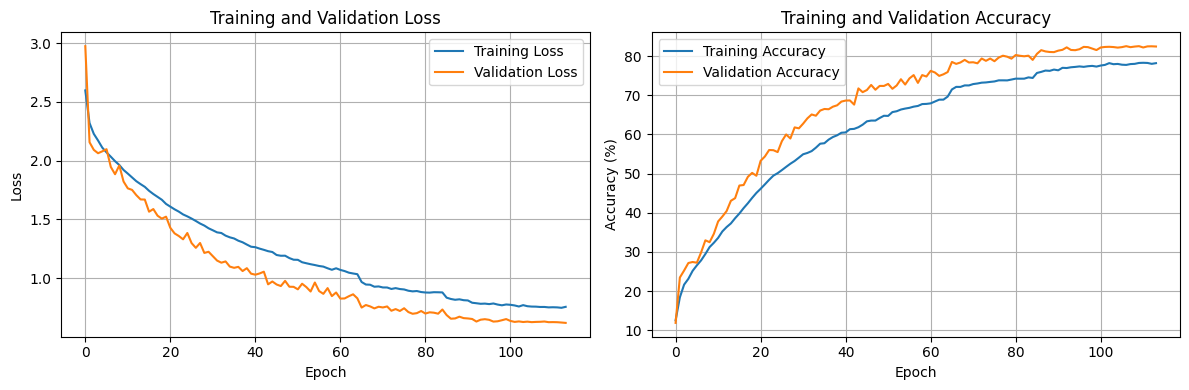

In [72]:
# Initialize model and print parameter count
model = SimpleClassifier().to(device)
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

# Train the model
model = train_model(model, train_dataloader, valid_dataloader, epochs=200)

# Save only the final model
save_model(model, 'model_checkpoints', 'final_model')


In [73]:
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

Number of parameters: 98524


In [74]:
# Test the model
test_model(model, test_dataloader)

Test Accuracy: 83.54%


83.54